# plotting correlation between heterogeneous reconstruction and MD trajectory
This notebook computes the correlation between frames of the MD trajectory and volumes reconstructed by cryoDRGN / cryoSPARC

# making an ensemble of structures and aligning them to the first volume
This part of the script pulls 50 structures from the pdb_dir and bundles them in a single .pdb file. Then the ensemble can be aligned to the first volume of the cryoDRGN reconstruction in ChimeraX by hand. The aligned ensemble should be saved as a .pdb file in the same directory as the cryoDRGN reconstruction.

In [2]:
# imports
import os
import numpy as np
import gemmi
import warnings
import itertools
import matplotlib.pyplot as plt
import pandas as pd

from joblib import Parallel, delayed
from tqdm import tqdm
from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.ndimage.filter.low_pass_filter import low_pass_filter


In [3]:
# functions
def filter_gemmi_model(model_gemmi, remove_sidechains=False):
    # remove ligand residues and all sidechain atoms
    list_of_residue_names = [
        "F2A", "H2A", "NLM", "NM5", "NM7", "NME"
    ]
    new_model_gemmi = gemmi.Model(model_gemmi.name)
    for chn in model_gemmi:
        new_chain_gemmi = gemmi.Chain(chn.name)
        for res in chn:
            if res.name not in list_of_residue_names:
                new_res_gemmi = gemmi.Residue()
                new_res_gemmi.name = res.name
                new_res_gemmi.seqid.num = res.seqid.num
                
                if remove_sidechains:
                    for atm in res:
                        if atm.name == "CA":
                            new_atm_gemmi = gemmi.Atom()
                            new_atm_gemmi.name = atm.name
                            new_atm_gemmi.pos = atm.pos
                            new_atm_gemmi.element = gemmi.Element(atm.element.name)
                            new_res_gemmi.add_atom(new_atm_gemmi)

                else:
                    for atm in res:
                        new_atm_gemmi = gemmi.Atom()
                        new_atm_gemmi.name = atm.name
                        new_atm_gemmi.pos = atm.pos
                        new_atm_gemmi.element = gemmi.Element(atm.element.name)
                        new_res_gemmi.add_atom(new_atm_gemmi)                  

                new_chain_gemmi.add_residue(new_res_gemmi)
        new_model_gemmi.add_chain(new_chain_gemmi)
    return new_model_gemmi

# functions
def compute_correlation(modelmap, targetmap, mask, i, j):
    """Compute the correlation between two maps"""
    
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
    # apply mask to both maps
    modelmap_masked = modelmap * mask
    targetmap_masked = targetmap * mask
    # compute the mean of the two maps
    mean_modelmap = np.mean(modelmap_masked)
    mean_targetmap = np.mean(targetmap_masked)
    # compute the standard deviation of the two maps
    std_modelmap = np.std(modelmap_masked)
    std_targetmap = np.std(targetmap_masked)
    # compute the correlation
    correlation = np.mean((modelmap_masked - mean_modelmap) * (targetmap_masked - mean_targetmap)) / (std_modelmap * std_targetmap)
    return correlation, i, j


In [37]:
# create an ensemble structure
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/"
pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/mnt/parakeet_storage4/ConformationSampling/DESRES-Trajectory_sarscov2-11021571-all-glueCA/even_sampling_8334"
output_dir = os.path.join(project_dir, "cryoDRGN", "analyze_320", "aligned_ensemble")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

pdb_files = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith(".pdb")]
pdb_files.sort()
N = 50
# sample N files from the total number of files, evenly spaced
pdb_files = pdb_files[::len(pdb_files)//N]

ensemble_gemmi = gemmi.Structure()
ensemble_CA_gemmi = gemmi.Structure()
for filename in pdb_files:
    pdb_path = os.path.join(pdb_dir, filename)
    frame_gemmi = gemmi.read_structure(pdb_path)
    frame_gemmi_filtered = filter_gemmi_model(frame_gemmi[0], remove_sidechains=False)
    ensemble_gemmi.add_model(frame_gemmi_filtered)
    frame_gemmi_CA = filter_gemmi_model(frame_gemmi[0], remove_sidechains=True)
    ensemble_CA_gemmi.add_model(frame_gemmi_CA)

# write the ensemble to a pdb file
ensemble_gemmi.write_pdb(os.path.join(output_dir, "ensemble.pdb"))
ensemble_CA_gemmi.write_pdb(os.path.join(output_dir, "ensemble_CA.pdb"))

In [38]:
for pdb_file in pdb_files:
    print(os.path.basename(pdb_file))

conformation_000000.pdb
conformation_000166.pdb
conformation_000332.pdb
conformation_000498.pdb
conformation_000664.pdb
conformation_000830.pdb
conformation_000996.pdb
conformation_001162.pdb
conformation_001328.pdb
conformation_001494.pdb
conformation_001660.pdb
conformation_001826.pdb
conformation_001992.pdb
conformation_002158.pdb
conformation_002324.pdb
conformation_002490.pdb
conformation_002656.pdb
conformation_002822.pdb
conformation_002988.pdb
conformation_003154.pdb
conformation_003320.pdb
conformation_003486.pdb
conformation_003652.pdb
conformation_003818.pdb
conformation_003984.pdb
conformation_004150.pdb
conformation_004316.pdb
conformation_004482.pdb
conformation_004648.pdb
conformation_004814.pdb
conformation_004980.pdb
conformation_005146.pdb
conformation_005312.pdb
conformation_005478.pdb
conformation_005644.pdb
conformation_005810.pdb
conformation_005976.pdb
conformation_006142.pdb
conformation_006308.pdb
conformation_006474.pdb
conformation_006640.pdb
conformation_006

In [9]:
# save a specific frame without the ligand residues
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/"
pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/mnt/parakeet_storage4/ConformationSampling/DESRES-Trajectory_sarscov2-11021571-all-glueCA/even_sampling_8334"
output_dir = os.path.join(project_dir, "cryoDRGN", "analyze_320", "aligned_ensemble")

conformation = 163

conformation_filename = f"conformation_{conformation:06d}.pdb"
conformation_path = os.path.join(pdb_dir, conformation_filename)
conformation_gemmi = gemmi.read_structure(conformation_path)
conformation_gemmi_filtered = filter_gemmi_model(conformation_gemmi[0], remove_sidechains=False)
conformation_struct_gemmi = gemmi.Structure()
conformation_struct_gemmi.add_model(conformation_gemmi_filtered)
conformation_struct_gemmi.write_pdb(os.path.join(output_dir, conformation_filename))


# plotting Correlation matrix

In [4]:
# inputs and parameters
n_frames = 51
resolution = 3
n_jobs = 12

project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/mnt/parakeet_storage4/ConformationSampling/DESRES-Trajectory_sarscov2-11021571-all-glueCA/even_sampling_8334"
vseries_dir = os.path.join(project_dir, "cryoDRGN", "analyze_320")
mask_filename = os.path.join(project_dir, "cryoDRGN", "analyze_320", "aligned_ensemble", "ensemble_map.mrc")
ensemble_filename = os.path.join(project_dir, "cryoDRGN", "analyze_320", "aligned_ensemble", "ensemble_aligned.pdb")
figures_dir = os.path.join(project_dir, "figures")
latent_coordinates = np.arange(0, 50)

frames = [r for r in os.listdir(pdb_dir) if r.endswith(".pdb")]
frames.sort()
frames = frames[::int(len(frames)/n_frames)]

volumes = [r for r in os.listdir(vseries_dir) if r.endswith(".mrc") and not r.endswith("inverted.mrc") and "mask" not in r]
volumes.sort()



In [5]:
# step 1: load each frame and compute the modelmap
vseries_vol0 = gemmi.read_ccp4_map(os.path.join(vseries_dir, volumes[0]))
unitcell = vseries_vol0.grid.unit_cell
size = vseries_vol0.grid.shape
vsize = vseries_vol0.grid.spacing[0]

# create list of frames
frames_fit = []
ensemble_fit_gemmi = gemmi.read_structure(ensemble_filename)
for mdl in ensemble_fit_gemmi:
    tmp_struc = gemmi.Structure()
    tmp_struc.add_model(mdl)
    frames_fit.append(tmp_struc)

modelmaps = []
for frame_gemmi in tqdm(frames_fit):
    map_from_model_unfiltered = convert_pdb_to_map(
        input_pdb=frame_gemmi,
        unitcell=unitcell,
        size=size,
        return_grid=False,
    )
    map_from_model_zyx = low_pass_filter(
        map_from_model_unfiltered, resolution, vsize
    )
    map_from_model = np.rot90(
        np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
    )
    modelmaps.append(map_from_model)

100%|██████████| 51/51 [22:15<00:00, 26.18s/it]


In [6]:
# step 2: correlate each modelmap with the vseries'

# load vseries
vseries_stack = []
for volume in volumes:
    vseries_vol = gemmi.read_ccp4_map(os.path.join(vseries_dir, volume))
    vseries_stack.append(np.array(vseries_vol.grid))

indecies = itertools.product(range(n_frames), range(len(volumes)))
mask = gemmi.read_ccp4_map(mask_filename)
mask_data = np.array(mask.grid, copy=False)
# threshold = mask_data[mask_data > 0].mean() - 2 * mask_data[mask_data > 0].std()
threshold = 0.1
mask_data[mask_data < threshold] = 0
mask_data[mask_data >= threshold] = 1
# mask_data = np.rot90(np.flip(mask_data, axis=0), axes=(2, 0))

correlations = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(compute_correlation)(modelmaps[i], vseries_stack[j], mask_data, i, j)
    for i, j in indecies
)
correlation_matrix = np.zeros((n_frames, len(volumes)))
for correlation, i, j in correlations:
    correlation_matrix[i, j] = correlation

print(f"correlation average: {np.mean(correlation_matrix)}")
print(f"correlation std: {np.std(correlation_matrix)}")
print(f"correlation min: {np.min(correlation_matrix)}")
print(f"correlation max: {np.max(correlation_matrix)}")


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    9.9s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   11.3s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   12.9s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:   15.6s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   17.9s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:   20.1s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:   22.2s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:   24.3s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   26.1s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:   28.8s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:   30.9s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:   33.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   35.8s
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

correlation average: 0.6517528325390709
correlation std: 0.08834393954066774
correlation min: 0.42234519507562934
correlation max: 0.8088763163768885


In [7]:
# save the correlation matrix
np.save(os.path.join(project_dir, "cryoDRGN", "analyze_320", "correlation_matrix.npy"), correlation_matrix)

In [4]:
# optionally, load the correlation matrix
correlation_matrix = np.load(os.path.join(project_dir, "cryoDRGN", "analyze_320", "correlation_matrix.npy"))

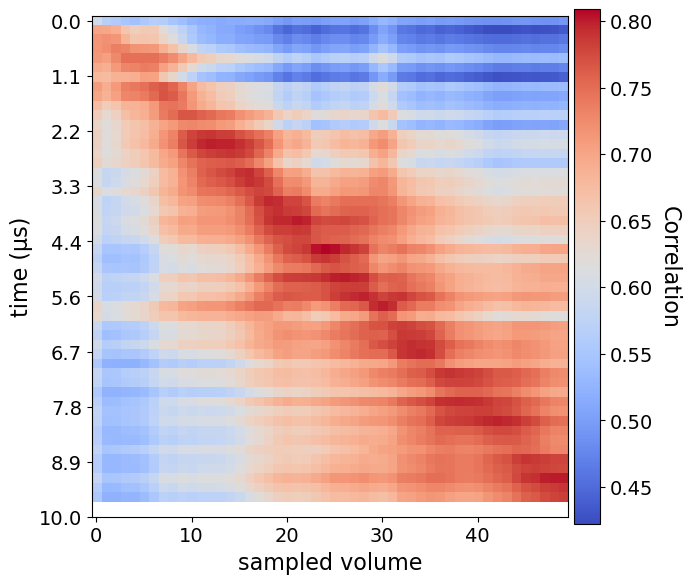

In [9]:
# step 3: plot the correlation matrix
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(correlation_matrix, cmap="coolwarm")
# change the xtick labels for latents
# ax.set_xticks(np.arange(len(volumes)))
# ax.set_xticklabels(
#     [np.round(r, 2) for r in latent_coordinates], rotation=90, fontsize=8)
# set the y-ticklabels to the frames in the pdb_dir
conformation_names = [float(r.split("_")[1].strip(".pdb")) for r in frames]
yticks = np.linspace(0, len(frames), 10)
yticklabels = np.round(np.linspace(0, 10, 10, dtype=float), 1)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel("time (\u03BCs)", fontsize=16)
ax.set_xlabel("sampled volume", fontsize=16)
# ax.set_yticklabels(np.round(np.linspace(0, 10, len(frames)), 2))
# ax.set_yticklabels(conformation_names)
# ax.set_yticklabels([np.round(r*1.2/1000, 1) for r in conformation_names])
# make a colorbar with the same size as the image
cbar = ax.figure.colorbar(ax.get_images()[0], ax=ax, orientation="vertical", pad=0.01, shrink=0.8)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Correlation", fontsize=16, rotation=270, labelpad=20)
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

# fig.savefig(os.path.join(figures_dir, f"{os.path.basename(vseries_dir)}_correlation_matrix.png"), dpi=300, bbox_inches="tight")
# fig.savefig(os.path.join(figures_dir, f"{os.path.basename(vseries_dir)}_correlation_matrix.pdf"), bbox_inches="tight")

In [ ]:
[np.round(r*1.2/1000, 1) for r in conformation_names]

[0.39121689 0.420966   0.50136312 0.523121   0.40999361 0.40465066
 0.44328147 0.5539773  0.41890325 0.43338811 0.4321999  0.4360047
 0.44503964 0.38351482 0.40006533 0.40079894 0.41409157 0.52286852
 0.42237042 0.53041432 0.40143174 0.54328068 0.4456324  0.39507519
 0.38682515 0.44674016 0.42214454 0.5110771  0.54018202 0.38117455
 0.38200183 0.39620609 0.38392792 0.4548163  0.51809608 0.50461308
 0.38403738 0.38672585 0.44839081 0.548738   0.40122026 0.54731468
 0.41194836 0.46102111 0.54404973 0.41435055 0.42214121 0.41770316
 0.38136079 0.40479955 0.41657247]


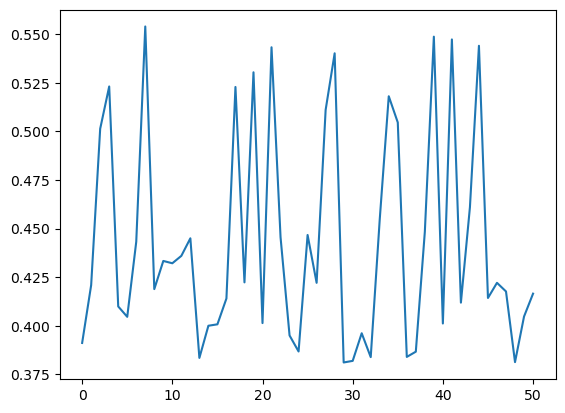

In [5]:
# print the values in the last column of the correlation matrix
print(correlation_matrix[:,0])
fig, ax = plt.subplots()
ax.plot(correlation_matrix[:,0])

In [7]:
# for each volume, print the frame with the highest and lowest correlation
results = {
    "volume": [],
    "best_frame": [],
    "best_correlation": [],
    "worst_frame": [],
    "worst_correlation": [],
}
for i, volume in enumerate(volumes):
    max_correlation = np.max(correlation_matrix[:, i])
    max_correlation_index = np.argmax(correlation_matrix[:, i])
    min_correlation = np.min(correlation_matrix[:, i])
    min_correlation_index = np.argmin(correlation_matrix[:, i])
    results["volume"].append(volume)
    results["best_frame"].append(frames[max_correlation_index])
    results["best_correlation"].append(max_correlation)
    results["worst_frame"].append(frames[min_correlation_index])
    results["worst_correlation"].append(min_correlation)

results_df = pd.DataFrame(results)
results_df.head(n=len(volumes))

,volume,best_frame,best_correlation,worst_frame,worst_correlation
0,vol_000.mrc,conformation_000489.pdb,0.716774,conformation_008150.pdb,0.554730
1,vol_001.mrc,conformation_000489.pdb,0.723066,conformation_008150.pdb,0.523048
2,vol_002.mrc,conformation_000489.pdb,0.736966,conformation_005868.pdb,0.522214
3,vol_003.mrc,conformation_000652.pdb,0.748178,conformation_005868.pdb,0.523335
4,vol_004.mrc,conformation_000652.pdb,0.748676,conformation_005868.pdb,0.522523
5,vol_005.mrc,conformation_000652.pdb,0.748349,conformation_005868.pdb,0.531752
6,vol_006.mrc,conformation_001141.pdb,0.760226,conformation_005868.pdb,0.547736
7,vol_007.mrc,conformation_001304.pdb,0.768888,conformation_005868.pdb,0.563817
8,vol_008.mrc,conformation_001304.pdb,0.763573,conformation_000000.pdb,0.556793
9,vol_009.mrc,conformation_001630.pdb,0.768273,conformation_000000.pdb,0.548102
